In [1]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit as curve_fit
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [3]:
#read in step response data
path = '/Volumes/eSSD0/Papers/JoC_gFBK/Data/SI/'

control = pk.load(open(path+'b.e12.pi-control.T31_g37.ctl.2_ctl_diag.pk','rb'))
si = pk.load(open(path+'b.e12.SI.T31_g37.039rad.ctl.2_ctl_diag.pk','rb'))
dts = si['tas']-si['tas'][0]


In [4]:
ts_fit = fit_sin(np.arange(len(dts)),dts)
ts_sin = ts_fit['fitfunc'](np.arange(len(dts)))
print('Tas data specs')
print( "Amplitude=%(amp)s\nAngular freq.=%(omega)s\nphase=%(phase)s\nfreq=%(freq)s\nperiod=%(period)s\noffset=%(offset)s" % ts_fit,'\n')

Tas data specs
Amplitude=0.3650798709635226
Angular freq.=0.39219516121252695
phase=-0.036655099328308405
freq=0.06241979856369645
period=16.020557948125184
offset=-0.040987701882782654 



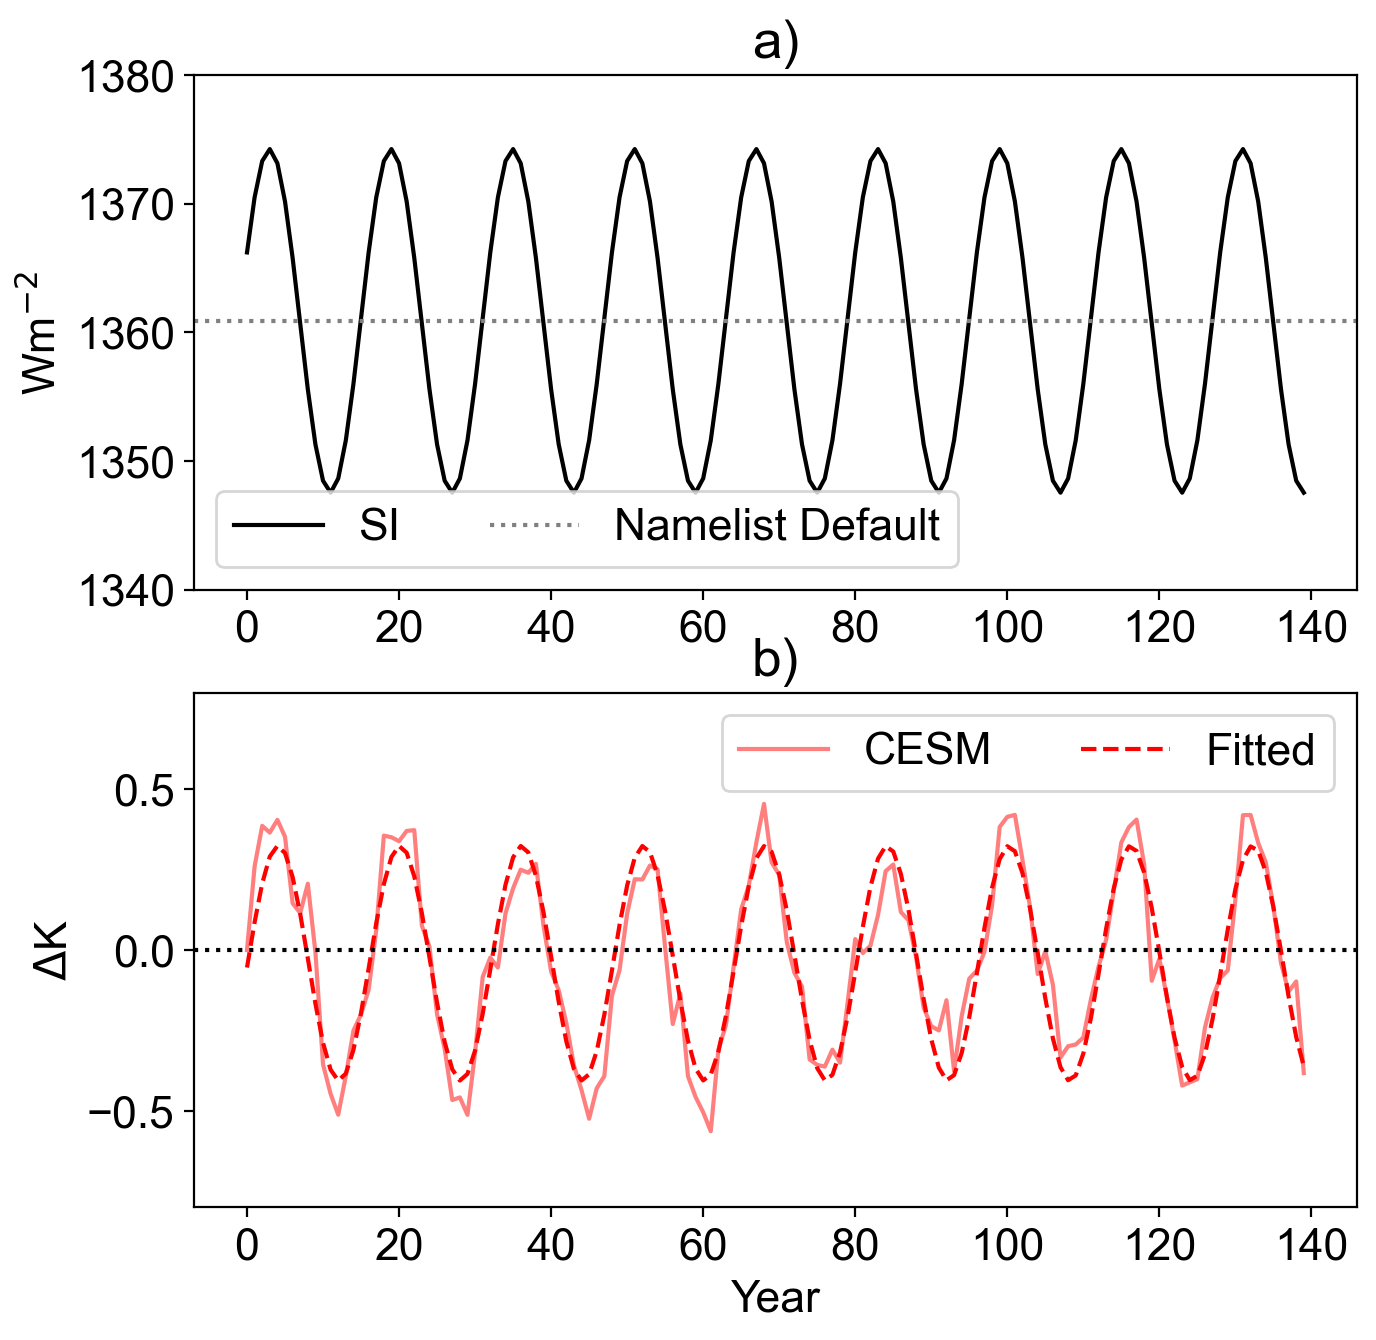

In [6]:
plt.figure(figsize=(7.5,7.5),dpi=200)
#plt.suptitle('System Identification')

plt.subplot(211)
plt.title('a)')
plt.plot(si['TSI'], color='k', label = 'SI')
plt.axhline(1360.89,color='grey',linestyle=':', label = 'Namelist Default')
plt.ylabel('Wm$^{-2}$')
plt.legend(ncol=2)
plt.ylim(1340,1380)

plt.subplot(212)
plt.title('b)')
plt.plot(dts,label='CESM', color='red',alpha=0.5)
plt.plot(ts_sin, color='red',linestyle='--', label = 'Fitted')
plt.axhline(0,linestyle=':', color='k')
plt.ylim(-0.8,0.8)

plt.legend(ncol=3)
plt.xlabel('Year')
plt.ylabel('$\Delta$K')
plt.savefig('SI_time.png',bbox_inches='tight')